In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp

import starfile

In [2]:
particles_star_path = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/particle_data/job290_run_it050_data.star").absolute()   
good_class_number = 7
model_directory = Path("/mnt/scratch/ribosomes/kas_k44a/particle_context/surfaces_all/").absolute()

model_binning = 10
pixel_size = 1.0825 # A/px

model_dimensions = [818, 1152, 480]
divide_model_dimensions_by = 10

grid_ts_numbers = [
    8, 12, 13,14,16, 17, 18, 33,40,41,42,44, 46, 48, 49,50, 
    51,52,53,56,57,61,62 ,64, 65, 66, 67, 68, 70, 71, 72, 73, 
    75, 76, 77, 78, 79, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 
    101, 102, 103, 107, 108, 110, 111, 112, 113, 114, 116, 118, 120, 122, 123, 124
]

In [3]:
particles_star = starfile.read(particles_star_path)
particles_df = particles_star['particles']
ts_names = particles_df['rlnTomoName'].unique()

grid_ts_names = [f"ts_{ts_number:03d}" for ts_number in grid_ts_numbers]
nogrid_ts_names = sorted(list(set(ts_names) - set(grid_ts_names)))
ts_names = nogrid_ts_names
print(f"ts_names: {ts_names}")
out_all_particles_df = particles_df.copy()[particles_df['rlnTomoName'].isin(ts_names)]
tomogram_dimensions = [dimension*model_binning for dimension in model_dimensions]
print(len(ts_names))

ts_names: ['ts_003', 'ts_004', 'ts_005', 'ts_006', 'ts_007', 'ts_009', 'ts_015', 'ts_020', 'ts_021', 'ts_022', 'ts_023', 'ts_024', 'ts_026', 'ts_027', 'ts_028', 'ts_029', 'ts_030', 'ts_031', 'ts_032', 'ts_034', 'ts_035', 'ts_036', 'ts_038', 'ts_039', 'ts_045', 'ts_047', 'ts_054', 'ts_055', 'ts_058', 'ts_060', 'ts_069', 'ts_074', 'ts_082', 'ts_097', 'ts_100', 'ts_104', 'ts_105', 'ts_106', 'ts_109', 'ts_117', 'ts_121']
41


In [4]:
# print grid ts names to file
with open(model_directory.parent / "grid_ts_names.txt", "w") as f:
    for ts_name in grid_ts_names:
        f.write(f"{ts_name}\n")

# print nogrid ts names to file
with open(model_directory.parent / "nogrid_ts_names.txt", "w") as f:
    for ts_name in nogrid_ts_names:
        f.write(f"{ts_name}\n")


In [5]:

distances_df = pd.DataFrame(columns=["DistanceToBottom"])

for ts_name in ts_names:
    model_file = model_directory / f"bottom/{ts_name}_bot.xyz"
    model_df = pd.read_csv(model_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * model_binning
    num_model_pts = model_df.shape[0]

    # Define an xy grid to interpolate over
    x_grid = np.linspace(0, tomogram_dimensions[0], int(model_dimensions[0] / divide_model_dimensions_by))
    y_grid = np.linspace(0, tomogram_dimensions[1], int(model_dimensions[1] / divide_model_dimensions_by))
    # Create a meshgrid from the x and y grids
    x_interp, y_interp = np.meshgrid(x_grid, y_grid)
    # Interpolate the model point values over the grid
    z_interp = np.empty((len(x_grid), len(y_grid)))
    interpolation = sp.interpolate.Rbf(model_df['x'], model_df['y'], model_df['z'], function='thin_plate', smooth=5, epsilon=5)
    z_interp = interpolation(x_interp, y_interp)

    model_surface = np.dstack((x_interp, y_interp, z_interp))

    # Get the particles for the current tomogram
    ts_particles_df = particles_df[particles_df['rlnTomoName'] == ts_name]
    ts_particles_xyz = ts_particles_df[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].to_numpy()

    distances = np.empty((ts_particles_xyz.shape[0], 1)) # shape is (num_particles, num_surfaces)

    for i, particle_i in enumerate(ts_particles_xyz):
        # Calculate the norm from the particle position to each interpolated point and keep the minimum
        distances[i] = np.min(np.linalg.norm(model_surface - particle_i, axis=2)) # or use nanmin
        closest_grid_pt_indices = np.unravel_index(np.argmin(np.linalg.norm(model_surface - particle_i, axis=2)), model_surface.shape[:2])
        closest_grid_pt = model_surface[closest_grid_pt_indices[0], closest_grid_pt_indices[1]]
        # Check if the particle is above or below the surface
        z_diff = - closest_grid_pt[2] + particle_i[2] 
        pos_or_neg = np.sign(z_diff)
        distances[i] = pos_or_neg * distances[i]

        #z_surface_check = model_surface[grid_xy_check[0], grid_xy_check[1], 2]
    # Collect the distances for each particle
    distances_df = pd.concat([distances_df, pd.DataFrame(distances, columns=["DistanceToBottom"])], ignore_index=True)

# Copy the original particles dataframe and add a new column for the distances
out_all_particles_df["DistanceToBottomNm"] = distances_df * pixel_size / 10 # convert from px to nm


In [6]:
distances_df = pd.DataFrame(columns=["DistanceToTop"])
for ts_name in ts_names:
    model_file = model_directory / f"top/{ts_name}_top.xyz"
    model_df = pd.read_csv(model_file, delim_whitespace=True, header=None, names=["x", "y", "z"]) * model_binning
    num_model_pts = model_df.shape[0]

    # Define an xy grid to interpolate over
    x_grid = np.linspace(0, tomogram_dimensions[0], int(model_dimensions[0] / divide_model_dimensions_by))
    y_grid = np.linspace(0, tomogram_dimensions[1], int(model_dimensions[1] / divide_model_dimensions_by))
    # Create a meshgrid from the x and y grids
    x_interp, y_interp = np.meshgrid(x_grid, y_grid)
    # Interpolate the model point values over the grid
    z_interp = np.empty((len(x_grid), len(y_grid)))
    interpolation = sp.interpolate.Rbf(model_df['x'], model_df['y'], model_df['z'], function='thin_plate', smooth=5, epsilon=5)
    z_interp = interpolation(x_interp, y_interp)

    model_surface = np.dstack((x_interp, y_interp, z_interp))

    ts_particles_df = particles_df[particles_df['rlnTomoName'] == ts_name]
    ts_particles_xyz = ts_particles_df[["rlnCoordinateX", "rlnCoordinateY", "rlnCoordinateZ"]].to_numpy()

    distances = np.empty((ts_particles_xyz.shape[0], 1)) # shape is (num_particles, num_surfaces)

    for i, particle_i in enumerate(ts_particles_xyz):
        # Calculate the norm from the particle position to each interpolated point and keep the minimum
        distances[i] = np.min(np.linalg.norm(model_surface - particle_i, axis=2)) # or use nanmin
        closest_grid_pt_indices = np.unravel_index(np.argmin(np.linalg.norm(model_surface - particle_i, axis=2)), model_surface.shape[:2])
        closest_grid_pt = model_surface[closest_grid_pt_indices[0], closest_grid_pt_indices[1]]
        # Check if the particle is above or below the surface
        z_diff = closest_grid_pt[2] - particle_i[2] 
        pos_or_neg = np.sign(z_diff)
        distances[i] = pos_or_neg * distances[i]

        #z_surface_check = model_surface[grid_xy_check[0], grid_xy_check[1], 2]
    # Collect the distances for each particle
    distances_df = pd.concat([distances_df, pd.DataFrame(distances, columns=["DistanceToTop"])], ignore_index=True)

out_all_particles_df["DistanceToTopNm"] = distances_df * pixel_size / 10 # convert from px to nm

In [7]:
out_aligning_particles_df = out_all_particles_df[out_all_particles_df['rlnClassNumber'] == good_class_number]

In [8]:
output_star_path = model_directory / f"nogrid_particle_distances_div{divide_model_dimensions_by}.star"
out_particles_star = particles_star.copy()
out_particles_star['particles'] = out_all_particles_df

starfile.write(out_particles_star, output_star_path, overwrite=True)

In [20]:
out_particles_star['particles']

,rlnTomoName,rlnCoordinateX,rlnCoordinateY,rlnCoordinateZ,rlnAngleRot,rlnAngleTilt,rlnAnglePsi,rlnOriginXAngst,rlnOriginYAngst,rlnOriginZAngst,...,rlnNormCorrection,rlnLogLikeliContribution,rlnMaxValueProbDistribution,rlnNrOfSignificantSamples,rlnGroupNumber,rlnTomoParticleName,rlnImageName,rlnCtfImage,DistanceToBottomNm,DistanceToTopNm
0,ts_003,1106.368068,3276.834069,2954.955427,116.148094,121.662691,140.741362,1.673126,-3.739370,-3.739370,...,1.0,6525056.0,0.762850,10,1,ts_003/1,PseudoSubtomo/job281/Subtomograms/ts_003/1_dat...,PseudoSubtomo/job281/Subtomograms/ts_003/1_wei...,188.569870,50.602698
1,ts_003,2031.084489,1744.760531,2918.639109,-126.026590,68.588475,-45.390900,-0.491870,-4.821870,-0.491870,...,1.0,6525198.0,0.567290,10,1,ts_003/2,PseudoSubtomo/job281/Subtomograms/ts_003/2_dat...,PseudoSubtomo/job281/Subtomograms/ts_003/2_wei...,202.256460,67.825991
2,ts_003,558.017107,2083.060746,3069.591428,103.794850,50.409448,-76.102150,-2.656870,0.590626,1.673126,...,1.0,6524959.0,0.478015,10,1,ts_003/3,PseudoSubtomo/job281/Subtomograms/ts_003/3_dat...,PseudoSubtomo/job281/Subtomograms/ts_003/3_wei...,212.484554,43.473161
3,ts_003,5809.215672,2939.998790,2146.853152,132.783071,94.184525,-34.499920,-4.821870,-0.491870,-1.574370,...,1.0,6524776.0,0.903337,10,1,ts_003/4,PseudoSubtomo/job281/Subtomograms/ts_003/4_dat...,PseudoSubtomo/job281/Subtomograms/ts_003/4_wei...,105.581068,144.317348
4,ts_003,4699.579471,5940.833790,3172.099108,36.011875,19.283196,128.392256,-6.986870,0.590626,1.673126,...,1.0,6525373.0,0.773365,10,1,ts_003/5,PseudoSubtomo/job281/Subtomograms/ts_003/5_dat...,PseudoSubtomo/job281/Subtomograms/ts_003/5_wei...,215.841758,34.887082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23584,ts_124,2157.752427,1407.291427,2442.380472,-22.070350,88.598630,112.934819,-0.491870,1.673126,4.920626,...,1.0,6501686.0,1.000000,1,109,ts_124/149,PseudoSubtomo/job281/Subtomograms/ts_124/149_d...,PseudoSubtomo/job281/Subtomograms/ts_124/149_w...,50.902181,47.960542
23585,ts_124,2571.328154,3744.832051,2455.712744,-133.634390,108.835624,-34.867530,-9.151870,9.250626,8.168126,...,1.0,6503580.0,0.999917,1,109,ts_124/150,PseudoSubtomo/job281/Subtomograms/ts_124/150_d...,PseudoSubtomo/job281/Subtomograms/ts_124/150_w...,63.793270,57.138749
23586,ts_124,2054.705107,1080.476471,2398.949427,-34.919350,135.205436,-51.264010,2.755626,-0.491870,-10.234370,...,1.0,6502565.0,1.000000,1,109,ts_124/151,PseudoSubtomo/job281/Subtomograms/ts_124/151_d...,PseudoSubtomo/job281/Subtomograms/ts_124/151_w...,44.197875,50.136638
23587,ts_124,6360.313107,5330.388753,2441.565064,29.115223,73.936055,-156.324880,-0.491870,1.673126,-3.739370,...,1.0,6501130.0,1.000000,1,109,ts_124/152,PseudoSubtomo/job281/Subtomograms/ts_124/152_d...,PseudoSubtomo/job281/Subtomograms/ts_124/152_w...,99.499650,50.462354


divide_model_dimensions_by = 1.0 ==> 27m 5.3s

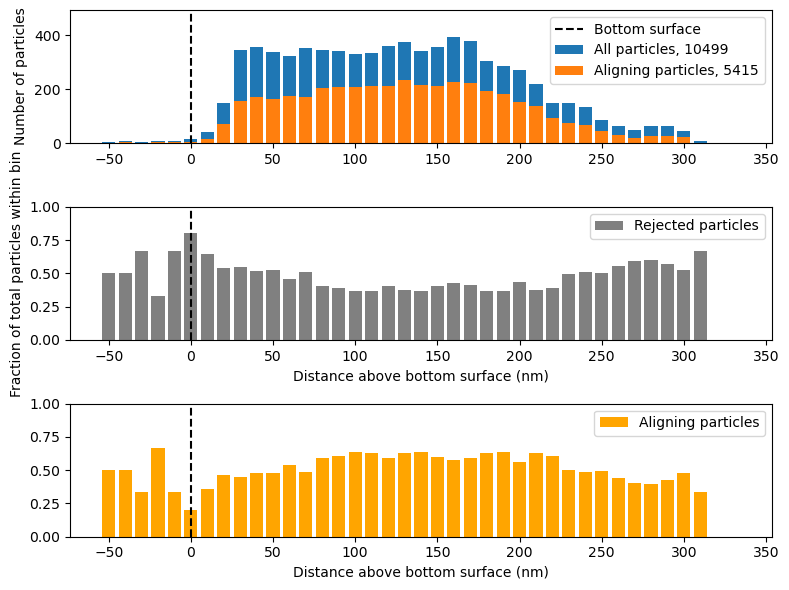

In [11]:
# Plot the distances

output_star_path = model_directory / f"nogrid_particle_distances_div{divide_model_dimensions_by}.star"
out_all_particles_df = starfile.read(output_star_path)['particles']
out_aligning_particles_df = out_all_particles_df[out_all_particles_df['rlnClassNumber'] == good_class_number]

fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(8, 6),)

bin_size_nm = 10 
bot_distance_bins = np.arange(-50, 350, bin_size_nm)
bot_all_particle_bins = np.empty(len(bot_distance_bins) - 1)
bot_aligning_particle_bins = np.empty(len(bot_distance_bins) - 1)

all_plot_df = pd.DataFrame()
aligning_plot_df = pd.DataFrame()
for i in range(len(bot_distance_bins) - 1):
    particles_in_bin = out_all_particles_df[(out_all_particles_df["DistanceToBottomNm"] > bot_distance_bins[i]) & (out_all_particles_df["DistanceToBottomNm"]  <= bot_distance_bins[i+1])]
    aligning_particles_in_bin = out_aligning_particles_df[(out_aligning_particles_df["DistanceToBottomNm"] > bot_distance_bins[i]) & (out_aligning_particles_df["DistanceToBottomNm"]  <= bot_distance_bins[i+1])]
    bot_all_particle_bins[i] = particles_in_bin.shape[0]
    bot_aligning_particle_bins[i] = aligning_particles_in_bin.shape[0]

ax1.bar(bot_distance_bins[:-1], bot_all_particle_bins, label=f"All particles, {out_all_particles_df.shape[0]}", width=0.8*(bot_distance_bins[1] - bot_distance_bins[0]))
ax1.bar(bot_distance_bins[:-1], bot_aligning_particle_bins, label=f"Aligning particles, {out_aligning_particles_df.shape[0]}", width=0.8*(bot_distance_bins[1] - bot_distance_bins[0]))
ax1.vlines(0, 0, 2500, label="Bottom surface", color="k", linestyles="--")
ax1.set_ylabel("Number of particles")
ax1.legend()
ax1.set_ylim(0, bot_all_particle_bins.max() + 100)

# Plot the percentage of particles in class 7 as a function of distance to top
bot_rejected_fraction = np.empty(len(bot_distance_bins) - 1)
bot_aligning_fraction = np.empty(len(bot_distance_bins) - 1)
for i in range(len(bot_distance_bins) - 1):
    particles_in_bin = out_all_particles_df[(out_all_particles_df["DistanceToBottomNm"] > bot_distance_bins[i]) & (out_all_particles_df["DistanceToBottomNm"]  <= bot_distance_bins[i+1])]
    try: 
        bot_rejected_fraction[i] = (- particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0] + particles_in_bin.shape[0]) / particles_in_bin.shape[0]
    except:
        # if div zero
        bot_rejected_fraction[i] = 0
    try:
        bot_aligning_fraction[i] = (particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0]) / particles_in_bin.shape[0]
    except:
        bot_aligning_fraction[i] = 0


ax2.bar(bot_distance_bins[:-1], bot_rejected_fraction, label="Rejected particles", width=0.8*(bot_distance_bins[1] - bot_distance_bins[0]), color="grey")
ax2.vlines(0, 0, 100, color="k", linestyles="--")
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(-50, 400, 50))
ax2.set_xlabel("Distance above bottom surface (nm)")
ax2.set_ylabel("Fraction of total particles within bin")
ax2.legend()

ax3.bar(bot_distance_bins[:-1], bot_aligning_fraction, label="Aligning particles", width=0.8*(bot_distance_bins[1] - bot_distance_bins[0]), color="orange")
ax3.vlines(0, 0, 1, color="k", linestyles="--")
ax3.legend()
ax3.set_ylim(0, 1)
ax3.set_xticks(np.arange(-50, 400, 50))
ax3.set_xlabel("Distance above bottom surface (nm)")

plt.tight_layout()
plt.savefig(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/nogrid_distance_to_bottom_div{divide_model_dimensions_by}grid_bin{bin_size_nm}nm.png", dpi=300)


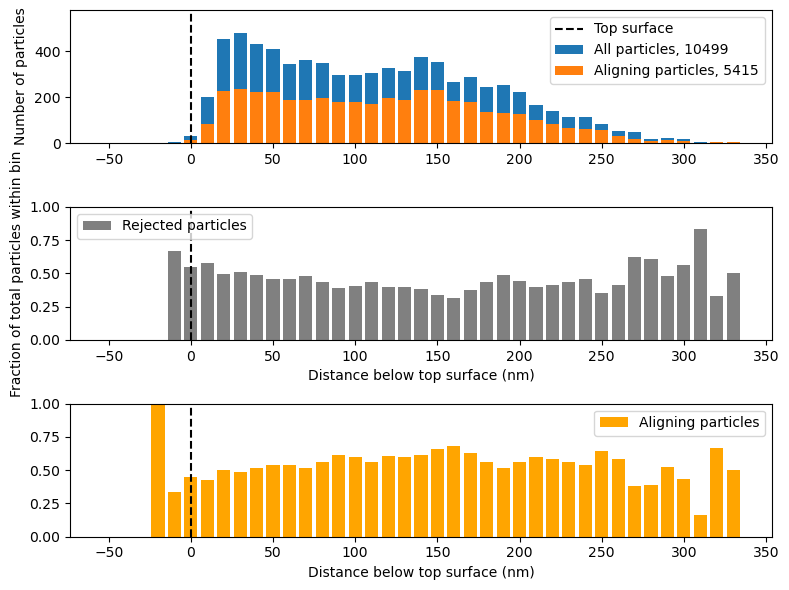

In [12]:
# Plot the distances

#out_all_particles_df = starfile.read(output_star_path)['particles']
out_aligning_particles_df = out_all_particles_df[out_all_particles_df['rlnClassNumber'] == good_class_number]

fig, [ax1,ax2,ax3] = plt.subplots(3, 1, figsize=(8, 6),)

top_distance_bins = np.arange(-50, 350, bin_size_nm)
top_all_particle_bins = np.empty(len(top_distance_bins) - 1)
top_aligning_particle_bins = np.empty(len(top_distance_bins) - 1)

all_plot_df = pd.DataFrame()
aligning_plot_df = pd.DataFrame()
for i in range(len(top_distance_bins) - 1):
    particles_in_bin = out_all_particles_df[(out_all_particles_df["DistanceToTopNm"] > top_distance_bins[i]) & (out_all_particles_df["DistanceToTopNm"]  <= top_distance_bins[i+1])]
    aligning_particles_in_bin = out_aligning_particles_df[(out_aligning_particles_df["DistanceToTopNm"] > top_distance_bins[i]) & (out_aligning_particles_df["DistanceToTopNm"]  <= top_distance_bins[i+1])]
    top_all_particle_bins[i] = particles_in_bin.shape[0]
    top_aligning_particle_bins[i] = aligning_particles_in_bin.shape[0]

ax1.bar(top_distance_bins[:-1], top_all_particle_bins, label=f"All particles, {out_all_particles_df.shape[0]}", width=0.8*(top_distance_bins[1] - top_distance_bins[0]))
ax1.bar(top_distance_bins[:-1], top_aligning_particle_bins, label=f"Aligning particles, {out_aligning_particles_df.shape[0]}", width=0.8*(top_distance_bins[1] - top_distance_bins[0]))
ax1.vlines(0, 0, 2500, label="Top surface", color="k", linestyles="--")
ax1.set_ylabel("Number of particles")
ax1.legend()
ax1.set_ylim(0, top_all_particle_bins.max() + 100)

# Plot the percentage of particles in class 7 as a function of distance to top
top_rejected_fraction = np.empty(len(top_distance_bins) - 1)
top_aligning_fraction = np.empty(len(top_distance_bins) - 1)
for i in range(len(top_distance_bins) - 1):
    particles_in_bin = out_all_particles_df[(out_all_particles_df["DistanceToTopNm"] > top_distance_bins[i]) & (out_all_particles_df["DistanceToTopNm"]  <= top_distance_bins[i+1])]
    try: 
        top_rejected_fraction[i] = (- particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0] + particles_in_bin.shape[0]) / particles_in_bin.shape[0]
    except:
        # if div zero
        top_rejected_fraction[i] = 0
    try:
        top_aligning_fraction[i] = (particles_in_bin[particles_in_bin["rlnClassNumber"] == 7].shape[0]) / particles_in_bin.shape[0]
    except:
        top_aligning_fraction[i] = 0


ax2.bar(top_distance_bins[:-1], top_rejected_fraction, label="Rejected particles", width=0.8*(top_distance_bins[1] - top_distance_bins[0]), color="grey")
ax2.vlines(0, 0, 100, color="k", linestyles="--")
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(-50, 400, 50))
ax2.set_xlabel("Distance below top surface (nm)")
ax2.set_ylabel("Fraction of total particles within bin")
ax2.legend()

ax3.bar(top_distance_bins[:-1], top_aligning_fraction, label="Aligning particles", width=0.8*(top_distance_bins[1] - top_distance_bins[0]), color="orange")
ax3.vlines(0, 0, 1, color="k", linestyles="--")
ax3.legend()
ax3.set_ylim(0, 1)
ax3.set_xticks(np.arange(-50, 400, 50))
ax3.set_xlabel("Distance below top surface (nm)")

plt.tight_layout()
plt.savefig(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/nogrid_distance_to_top_div{divide_model_dimensions_by}grid_bin{bin_size_nm}nm.png", dpi=300)


(0.0, 4800.0)

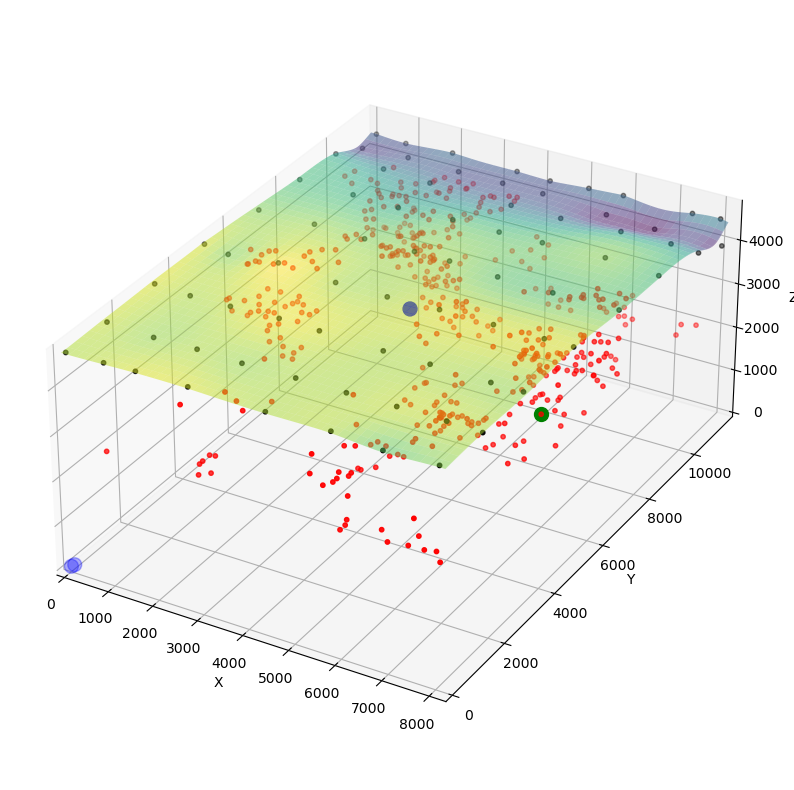

In [10]:
fig = plt.figure(figsize=(10, 10))
fig.tight_layout()
ax = fig.add_subplot(111, projection="3d")
index = 5
# Plot the interpolated surface
ax.plot_surface(x_interp, y_interp, z_interp, cmap="viridis", alpha=0.5)
# Plot particles and model points
ax.scatter(ts_particles_df["rlnCoordinateX"], ts_particles_df["rlnCoordinateY"], ts_particles_df["rlnCoordinateZ"], color="red", s=10)
ax.scatter(model_df["x"], model_df["y"], model_df["z"], color="black", s=10)
ax.scatter(model_surface[index][0], model_surface[index][1], model_surface[index][2], color="blue", s=100)
ax.scatter(particle_i[0], particle_i[1], particle_i[2], color="green", s=100)
# Draw an arrow from one_particle_df down in Z
#for i in range(ts_particles.shape[0]):
#    ax.quiver(
#        ts_particles[i, 0], ts_particles[i, 1], ts_particles[i, 2],
#        0, 0, distances[i], color="red"
#    )

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(0, tomogram_dimensions[0])
ax.set_ylim(0, tomogram_dimensions[1])
ax.set_zlim(0, tomogram_dimensions[2])

In [13]:
# Write out number of particles in each bin in a csv
out_df = pd.DataFrame({"DistanceToBottomNm": bot_distance_bins[:-1], "AllParticles": bot_all_particle_bins, "AligningParticles": bot_aligning_particle_bins})
out_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/numparticles_hole_bot_plot_data_bin{bin_size_nm}nm.csv", index=False)
out_percent_df = pd.DataFrame({"DistanceToBottomNm": bot_distance_bins[:-1], "RejectedFraction": bot_rejected_fraction, "AligningFraction": bot_aligning_fraction})
out_percent_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/fraction_hole_bot_plot_data_bin{bin_size_nm}nm.csv", index=False)

out_df = pd.DataFrame({"DistanceToTopNm": top_distance_bins[:-1], "AllParticles": top_all_particle_bins, "AligningParticles": top_aligning_particle_bins})
out_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/numparticles_hole_top_plot_data_bin{bin_size_nm}nm.csv", index=False)
out_percent_df = pd.DataFrame({"DistanceToBottomNm": top_distance_bins[:-1], "RejectedFraction": top_rejected_fraction, "AligningFraction": top_aligning_fraction})
out_percent_df.to_csv(f"/mnt/scratch/ribosomes/kas_k44a/particle_context/fraction_hole_top_plot_data_bin{bin_size_nm}nm.csv", index=False)